In [1]:
import itertools

import matplotlib.pyplot as plt

# Optimization modeling library
from aqmodels import (
    Comparator,
    Model,
    Solution,
    quicksum,
)
from aqmodels.transformations import (
    AnalysisCache,
    MaxBiasAnalysis,
    PassManager,
    TransformationPass,
    ActionType,
)

# Classical optimization
from scipy.optimize import minimize

# Import model data
from model.data import ConventionCenter, Schedule, SessionChair
from model.visualization import plot_floor_plan, plot_satisfaction

# Import utils (from last notebook)
from utils.sampling import cost_function, sample
from utils.qaoa import qaoa_circ
from utils.

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

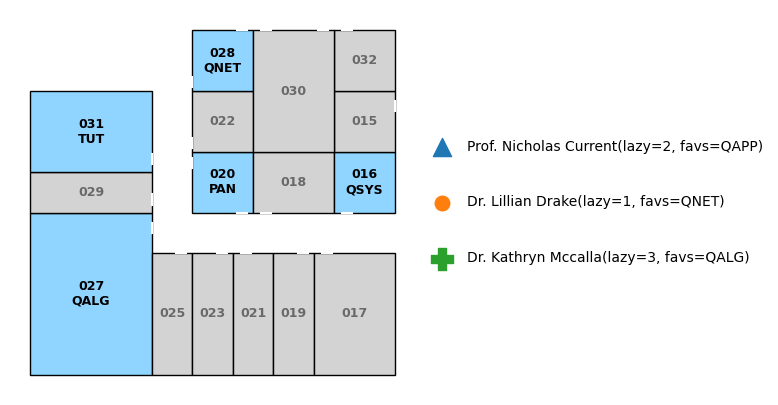

In [2]:
center = ConventionCenter.generate()
schedule = Schedule.random(5, center, seed=5)
chairs = SessionChair.random_chairs(3, seed=1)

satisfaction = 2

plot_floor_plan(center, schedule=schedule, chairs=chairs)

$$ \begin{align}
\underset{x}{\mathrm{argmin}}& \sum_{i\in C} \ell_i \sum_{r > r' \in R} d_{r,r'} x_{r, i} x_{r', i} - \delta \sum_{i \in C} \sum_{r \in R_i} x_{r, i}\\
\text{s.t.} & \sum_{i \in C} x_{r, i} = 1 \quad \forall r \in R
\end{align} $$

In [3]:
# Initialize minimization model
model = Model("Session chair assignment")

# Add binary variables to the optimization model
x = {}
for r in schedule.rooms():
    for i in range(len(chairs)):
        # If no vtype is specified, binary vtype is selected by default
        x[r, i] = model.add_variable(f"x_{r}_{i}")

# Objective function part 1: Minimize total distance to travel for every session chair
distance = center.distance_map
model.objective += quicksum(
    round(chair.lazy * distance[room_a, room_b], 1) * x[room_a, i] * x[room_b, i]
    for i, chair in enumerate(chairs)
    for room_a, room_b in itertools.combinations(schedule.rooms(), r=2)
)

# Objective function part 2: Maximize satisfaction for chairing favorite sessions
rev_map = {v: k for k, v in schedule.items()}
model.objective -= quicksum(
    satisfaction * x[rev_map[fav], i]
    for i, chair in enumerate(chairs)
    for fav in chair.favourites
    if fav in rev_map
)


# one-hot constraints: Every room needs to have exactly one chair
for room in schedule.rooms():
    model.add_constraint(
        quicksum(x[room, i] for i in range(len(chairs))) == 1, f"chair_in_{room}"
    )

print(model)

Model: Session chair assignment
Minimize
  15 * x_016_0 * x_028_0 + 8 * x_016_0 * x_020_0 + 10 * x_016_0 * x_031_0 
  + 9.6 * x_016_0 * x_027_0 + 7.5 * x_016_1 * x_028_1 + 4 * x_016_1 * x_020_1 
  + 5 * x_016_1 * x_031_1 + 4.8 * x_016_1 * x_027_1 + 22.5 * x_016_2 * x_028_2 
  + 12 * x_016_2 * x_020_2 + 15 * x_016_2 * x_031_2 + 14.4 * x_016_2 * x_027_2 
  + 7 * x_028_0 * x_020_0 + 7.8 * x_028_0 * x_031_0 + 10.8 * x_028_0 * x_027_0 
  + 3.5 * x_028_1 * x_020_1 + 3.9 * x_028_1 * x_031_1 + 5.4 * x_028_1 * x_027_1 
  + 10.5 * x_028_2 * x_020_2 + 11.7 * x_028_2 * x_031_2 
  + 16.2 * x_028_2 * x_027_2 + 2 * x_020_0 * x_031_0 + 3.8 * x_020_0 * x_027_0 
  + x_020_1 * x_031_1 + 1.9 * x_020_1 * x_027_1 + 3 * x_020_2 * x_031_2 
  + 5.7 * x_020_2 * x_027_2 + 3.4 * x_031_0 * x_027_0 + 1.7 * x_031_1 * x_027_1 
  + 5.1 * x_031_2 * x_027_2 - 2 * x_028_1 - 2 * x_027_2
Subject To
  chair_in_016: x_016_0 + x_016_1 + x_016_2 == 1
  chair_in_028: x_028_0 + x_028_1 + x_028_2 == 1
  chair_in_020: x_020_0 + x_

$$ \begin{align}
\underset{x}{\mathrm{argmin}}& \sum_{i\in C} \sum_{r > r' \in R} d_{r,r'} x_{r, i} x_{r', i} - \delta \sum_{i \in C} \sum_{r \in R_i} x_{r, i} + \lambda \sum_{r \in R} \left(1 - \sum_{i \in C} x_{r, i}\right)^2
\end{align} $$

In [4]:
penalty = 50

# Initialize minimization model
model2 = Model("Session chair assignment (penalty)")

# Add binary variables to the optimization model
x2 = {}
for r in schedule.rooms():
    for i in range(len(chairs)):
        # If no vtype is specified, binary vtype is selected by default
        x2[r, i] = model2.add_variable(f"x_{r}_{i}")

# Objective function part 1: Minimize total distance to travel for every session chair
distance = center.distance_map
model2.objective += quicksum(
    round(chair.lazy * distance[room_a, room_b], 1) * x2[room_a, i] * x2[room_b, i]
    for i, chair in enumerate(chairs)
    for room_a, room_b in itertools.combinations(schedule.rooms(), r=2)
)

# Objective function part 2: Maximize satisfaction for chairing favorite sessions
rev_map = {v: k for k, v in schedule.items()}
model2.objective -= quicksum(
    satisfaction * x2[rev_map[fav], i]
    for i, chair in enumerate(chairs)
    for fav in chair.favourites
    if fav in rev_map
)

# one-hot constraints: Every room needs to have exactly one chair
for room in schedule.rooms():
    model2.objective += (
        penalty * (quicksum(x2[room, i] for i in range(len(chairs))) - 1) ** 2
    )

print(model2)

Model: Session chair assignment (penalty)
Minimize
  100 * x_016_0 * x_016_1 + 100 * x_016_0 * x_016_2 + 15 * x_016_0 * x_028_0 
  + 8 * x_016_0 * x_020_0 + 10 * x_016_0 * x_031_0 + 9.6 * x_016_0 * x_027_0 
  + 100 * x_016_1 * x_016_2 + 7.5 * x_016_1 * x_028_1 + 4 * x_016_1 * x_020_1 
  + 5 * x_016_1 * x_031_1 + 4.8 * x_016_1 * x_027_1 + 22.5 * x_016_2 * x_028_2 
  + 12 * x_016_2 * x_020_2 + 15 * x_016_2 * x_031_2 + 14.4 * x_016_2 * x_027_2 
  + 100 * x_028_0 * x_028_1 + 100 * x_028_0 * x_028_2 + 7 * x_028_0 * x_020_0 
  + 7.8 * x_028_0 * x_031_0 + 10.8 * x_028_0 * x_027_0 + 100 * x_028_1 * x_028_2
  + 3.5 * x_028_1 * x_020_1 + 3.9 * x_028_1 * x_031_1 + 5.4 * x_028_1 * x_027_1 
  + 10.5 * x_028_2 * x_020_2 + 11.7 * x_028_2 * x_031_2 
  + 16.2 * x_028_2 * x_027_2 + 100 * x_020_0 * x_020_1 + 100 * x_020_0 * x_020_2
  + 2 * x_020_0 * x_031_0 + 3.8 * x_020_0 * x_027_0 + 100 * x_020_1 * x_020_2 
  + x_020_1 * x_031_1 + 1.9 * x_020_1 * x_027_1 + 3 * x_020_2 * x_031_2 
  + 5.7 * x_020_2 * x_0

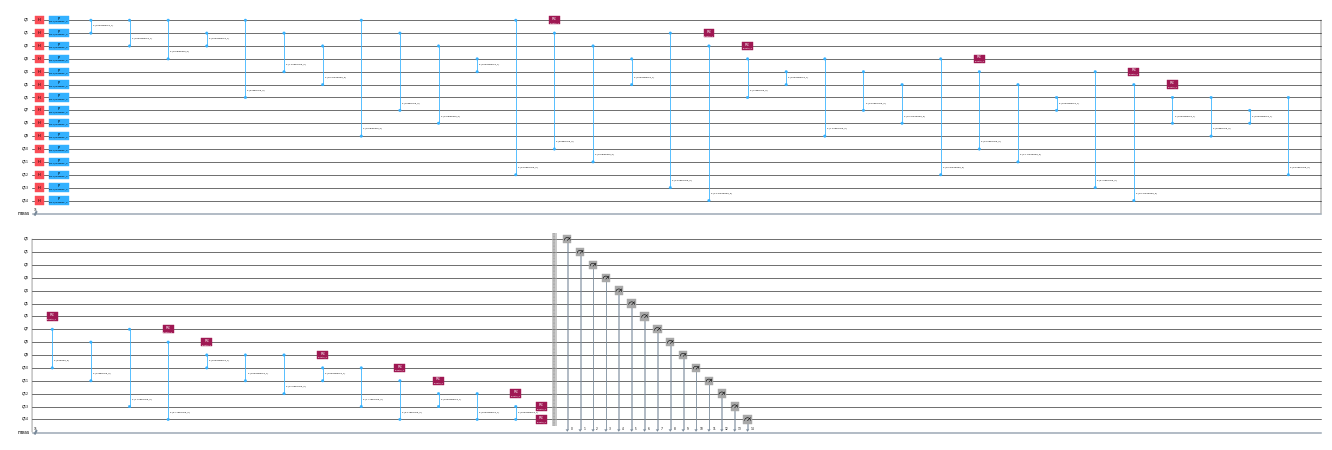

In [5]:
qaoa_circ(model2).draw("mpl", scale=0.2, fold=100)

## Enter Transformations

In [6]:
pass_manager = PassManager([MaxBiasAnalysis()])
print(pass_manager)

PassManager
🔎 max-bias


In [7]:
print(pass_manager.run(model).cache)

 max-bias: MaxBias(val=22.5)


In [8]:
class QuadraticPenaltyPass(TransformationPass):
    """Integrates equality constraints as quadratic penalties."""

    def __init__(self, penalty_factor: float = 5.0):
        self.penalty_factor = penalty_factor

    @property
    def name(self):
        return "quadratic-penalty"

    @property
    def requires(self):
        return ["max-bias"]

    @property
    def invalidates(self):
        return ["max-bias"]

    def run(self, model: Model, cache: AnalysisCache):
        max_bias = cache["max-bias"]

        penalty = self.penalty_factor * max_bias.val

        to_remove = []
        for i, c in enumerate(model.constraints):
            if c.comparator != Comparator.Eq:
                continue
            to_remove.append(c.name or i)
            model.objective += penalty * (c.lhs - c.rhs) ** 2

        if len(to_remove) == 0:
            return TransformationOutcome.nothing(model)

        for r in reversed(to_remove):
            model.constraints.remove(r)

        return model, ActionType.DidTransform

    # Backwards function needs to be implemented. Does inverse transformation if necessary
    def backwards(self, solution: Solution, cache: AnalysisCache):
        return solution

In [9]:
pass_manager = PassManager(
    [MaxBiasAnalysis(), QuadraticPenaltyPass(penalty_factor=6), MaxBiasAnalysis()]
)
ir = pass_manager.run(model)

In [10]:
scale = 1 / ir.cache["max-bias"].val
# scale=1

=== Running optimization for p=1 layers ===
Circuit depth: 23, Parameters: 2
Iteration 5: Energy = 247.995
Iteration 10: Energy = 242.495
Iteration 15: Energy = 246.111
Iteration 20: Energy = 247.949
-------------------------
Energy: 240.304
Best objective value: 4.6

=== Running optimization for p=2 layers ===
Circuit depth: 32, Parameters: 4
Iteration 5: Energy = 257.374
Iteration 10: Energy = 259.735
Iteration 15: Energy = 261.678
Iteration 20: Energy = 255.602
-------------------------
Energy: 254.808
Best objective value: 4.6

=== Running optimization for p=3 layers ===
Circuit depth: 47, Parameters: 6
Iteration 5: Energy = 223.732
Iteration 10: Energy = 220.342
Iteration 15: Energy = 217.042
Iteration 20: Energy = 221.308
Iteration 25: Energy = 217.359
-------------------------
Energy: 211.169
Best objective value: 4.4

=== Running optimization for p=4 layers ===
Circuit depth: 56, Parameters: 8
Iteration 5: Energy = 218.605
Iteration 10: Energy = 209.808
Iteration 15: Energy = 1

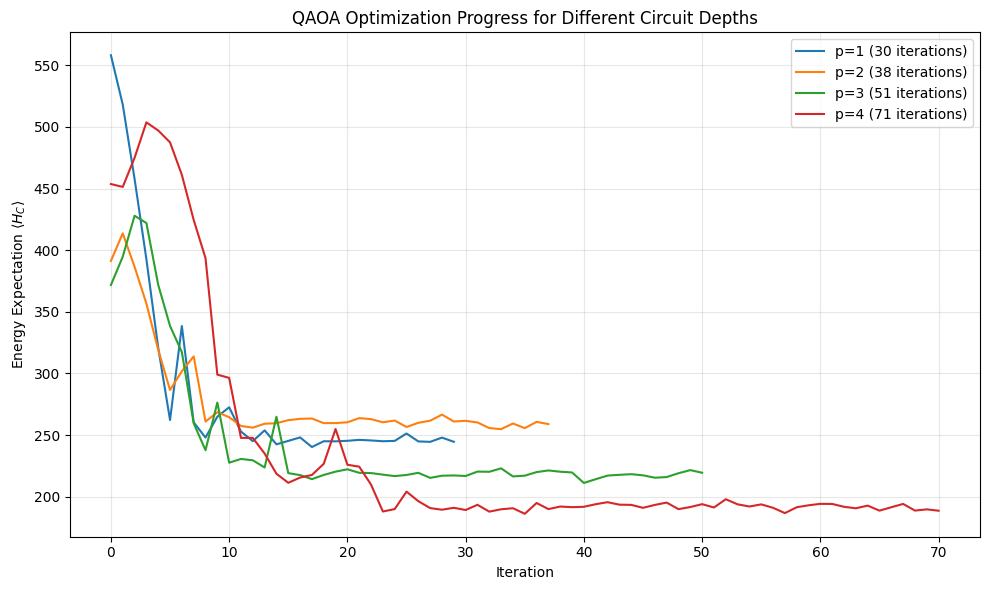

In [11]:
best = None
final_solution = None
all_logs = {}

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
# ax.axhline(1, color="k", linestyle="dashed", label="optimal value")
# ax.axhline(0.878, color="gray", linestyle="dashed", label="Goemans-Williamson approximation ratio")
ax.set_xlabel("Iteration")
ax.set_ylabel(r"Energy Expectation $\langle H_C \rangle$")
ax.set_title("QAOA Optimization Progress for Different Circuit Depths")
plt.draw()

# Run QAOA for different numbers of layers
for p in range(1, 5):
    print(f"=== Running optimization for p={p} layers ===")

    current_it = 1

    def progress_callback(*args):
        """Callback function to print optimization progress."""
        global current_it
        if current_it % 5 == 0:
            print(f"Iteration {current_it}: Energy = {all_logs[p][-1]:.3f}")
        current_it += 1

    # Create QAOA circuit with p layers
    circ = qaoa_circ(ir.model, p, scale=scale)
    all_logs[p] = []

    print(f"Circuit depth: {circ.depth()}, Parameters: {len(circ.parameters)}")

    # Run classical optimization
    initial_params = [0.25] * (2 * p)  # p beta parameters + p gamma parameters

    result = minimize(
        cost_function,  # Function to minimize
        initial_params,  # Initial parameters
        args=(ir.model, circ, all_logs[p], 5000),  # Additional arguments
        method="COBYLA",  # Optimization algorithm
        options={"rhobeg": 0.1},  # COBYLA-specific options
        callback=progress_callback,  # Progress monitoring
    )

    # Plot the optimization trajectory
    ax.plot(all_logs[p], label=f"p={p} ({len(all_logs[p])} iterations)")

    final_solution = sample(model, circ, result.x)
    best = final_solution.best()

    print("-------------------------")
    print(f"Energy: {result.fun:.3f}")
    print(f"Best objective value: {best.obj_value}")
    print()


print("\n=== Final Results ===")
print(f"Best objective value: {best.obj_value}")
print(f"Final energy: {result.fun:.3f}")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();

In [12]:
final_solution.feasibility_ratio()

0.283

In [13]:
print(final_solution)

x_016 x_016 x_016 x_028 x_028 x_028 x_020 x_020 x_020     │ feas raw obj count
    1     0     0     0     1     0     0     1     0 ... │    t   ? 4.4     1
    1     0     0     0     0     1     0     1     0 ... │    t   ? 4.6     2
    0     0     1     1     0     0     0     1     0 ... │    t   ? 4.6     1
    0     0     1     0     1     0     0     1     0 ... │    t   ? 4.9     2
    0     0     1     0     1     0     1     0     0 ... │    t   ? 5.4     2
    0     1     0     0     1     0     1     0     0 ... │    t   ? 5.5     2
    1     0     0     0     1     0     0     0     1 ... │    t   ? 5.6     2
    0     0     1     0     1     0     1     0     0 ... │    t   ? 5.7     1
    1     0     0     0     1     0     0     0     1 ... │    t   ? 6.4     1
    0     1     0     1     0     0     0     1     0 ... │    t   ? 7.1     1
...

Total samples: 808
Total variables: 15


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

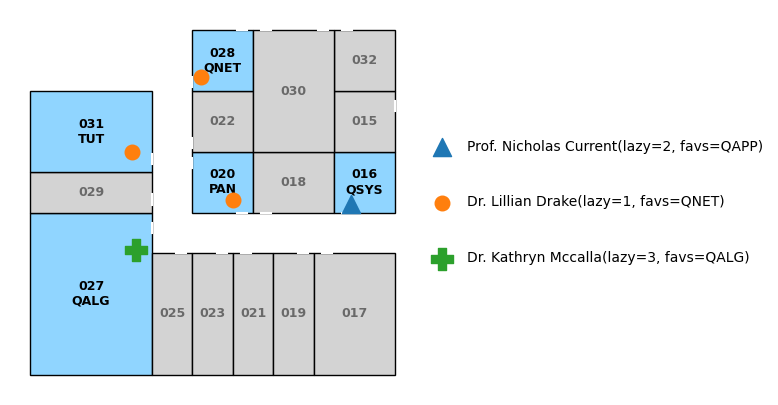

In [14]:
assignment = [
    (chair.name, room)
    for i, chair in enumerate(chairs)
    for room in schedule.rooms()
    if best.sample[x[room, i]]
]
plot_floor_plan(center, schedule=schedule, chairs=chairs, assignment=assignment)

(<Figure size 300x300 with 1 Axes>, <Axes: ylabel='Satisfaction'>)

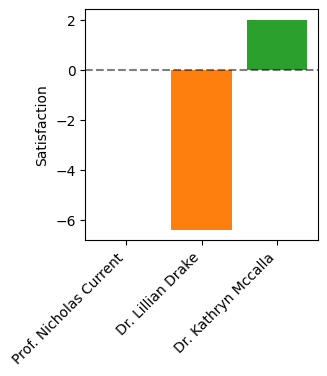

In [15]:
plot_satisfaction(center, schedule, chairs, assignment)